## Preprocessing the data

Create a TimeSeries object from a Pandas DataFrame, and split it in train/validation series:

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
import holidays
from darts import TimeSeries
from darts.models import NaiveSeasonal, Theta, RegressionModel, LightGBMModel
from darts.metrics import mape, rmse, mae

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)
import pandas as pd
from darts import TimeSeries

# Read a pandas DataFrame 2023
load2023 = pd.read_csv("Load_Data/Total Load - Day Ahead _ Actual_2023.csv", delimiter=",")
weather_data= pd.read_csv("Temperature Data/smhi-opendata_1_98230_202301_202412.csv", delimiter=";",skiprows=9)

# Change the timestamp following the dataseries for DARTS
load2023['Time (UTC)'] = load2023['Time (UTC)'].str.split(' - ').str[0]
# Delete the initial day ahead forecast data
load2023 = load2023.drop('Day-ahead Total Load Forecast [MW] - BZN|SE3',axis=1)   
# Change the name to simple name
load2023 = load2023.rename(columns={'Time (UTC)': 'completetime', 'Actual Total Load [MW] - BZN|SE3': 'Load'})
# Convert 'time' to datetime for easier splitting
load2023['datetime'] = pd.to_datetime(load2023['completetime'], format='%d.%m.%Y %H:%M')
load2023 = load2023.drop(['completetime'], axis=1)
# Adding the column temprature
load2023['Temperature']=weather_data['Lufttemperatur']

# Reorder the column
load2023 = load2023[['datetime', 'Load','Temperature']]

print(load2023)




                datetime   Load  Temperature
0    2023-01-01 00:00:00   8943          3.6
1    2023-01-01 01:00:00   8929          3.0
2    2023-01-01 02:00:00   8887          2.6
3    2023-01-01 03:00:00   8859          2.4
4    2023-01-01 04:00:00   8880          2.0
...                  ...    ...          ...
8755 2023-12-31 19:00:00  11561         -1.9
8756 2023-12-31 20:00:00  11276         -1.7
8757 2023-12-31 21:00:00  11035         -1.5
8758 2023-12-31 22:00:00  10831         -1.9
8759 2023-12-31 23:00:00  10722         -1.9

[8760 rows x 3 columns]


Adding features to this dataset can help us better understand it. Let's start with some simple calendar features like day of week and time of day. 

In [22]:
load2023 = load2023.reset_index(drop=True)
load2023['Day_of_week'] = load2023['datetime'].dt.dayofweek
load2023['Hour_of_day'] = load2023['datetime'].dt.hour
load2023 = load2023.set_index('datetime')
load2023

,Load,Temperature,Day_of_week,Hour_of_day
datetime,,,,
2023-01-01 00:00:00,8943,3.6,6,0
2023-01-01 01:00:00,8929,3.0,6,1
2023-01-01 02:00:00,8887,2.6,6,2
2023-01-01 03:00:00,8859,2.4,6,3
2023-01-01 04:00:00,8880,2.0,6,4
...,...,...,...,...
2023-12-31 19:00:00,11561,-1.9,6,19
2023-12-31 20:00:00,11276,-1.7,6,20
2023-12-31 21:00:00,11035,-1.5,6,21


<Axes: xlabel='datetime'>

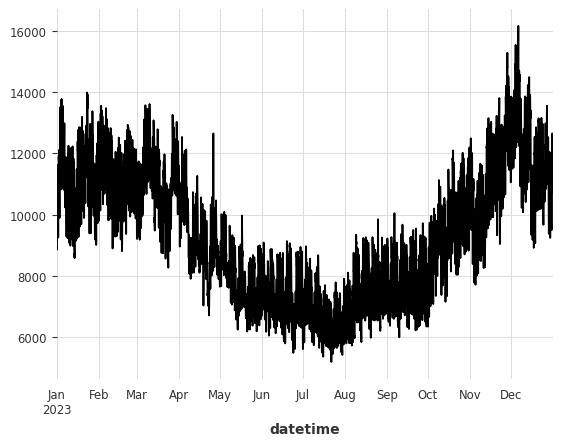

In [23]:
load2023['Load'].plot()
#load2023.plot()

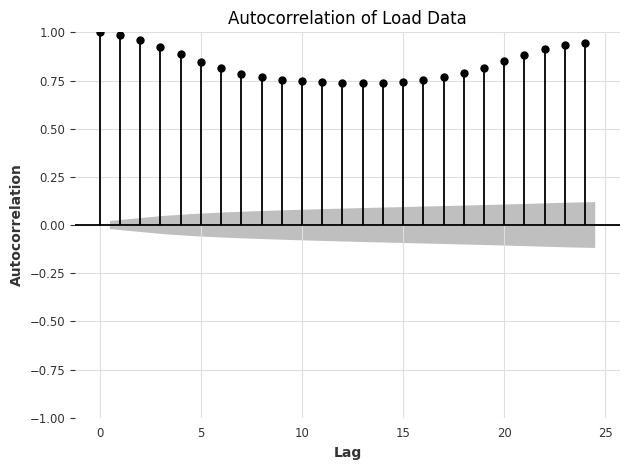

In [24]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Assuming your data is in a DataFrame called 'data'
# and 'load' is the column you're analyzing

# Plot the ACF
plot_acf(load2023['Load'], lags=24)  # You can adjust the lags value as needed
plt.title('Autocorrelation of Load Data')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.tight_layout()
plt.show()


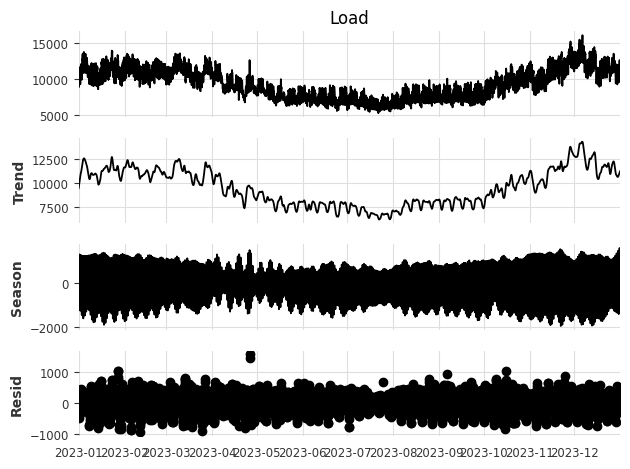

In [25]:
from statsmodels.tsa.seasonal import STL
result = STL(load2023['Load'], period=24).fit()
_ = result.plot()

In [26]:
load2023

,Load,Temperature,Day_of_week,Hour_of_day
datetime,,,,
2023-01-01 00:00:00,8943,3.6,6,0
2023-01-01 01:00:00,8929,3.0,6,1
2023-01-01 02:00:00,8887,2.6,6,2
2023-01-01 03:00:00,8859,2.4,6,3
2023-01-01 04:00:00,8880,2.0,6,4
...,...,...,...,...
2023-12-31 19:00:00,11561,-1.9,6,19
2023-12-31 20:00:00,11276,-1.7,6,20
2023-12-31 21:00:00,11035,-1.5,6,21


In [32]:
sweden_holidays = holidays.CountryHoliday('SE')
load2023['Holidays'] = [int(date in sweden_holidays) for date in load2023.index.date]
load2023

,Load,Temperature,Day_of_week,Hour_of_day,Holidays
datetime,,,,,
2023-01-01 00:00:00,8943,3.6,6,0,1
2023-01-01 01:00:00,8929,3.0,6,1,1
2023-01-01 02:00:00,8887,2.6,6,2,1
2023-01-01 03:00:00,8859,2.4,6,3,1
2023-01-01 04:00:00,8880,2.0,6,4,1
...,...,...,...,...,...
2023-12-31 19:00:00,11561,-1.9,6,19,1
2023-12-31 20:00:00,11276,-1.7,6,20,1
2023-12-31 21:00:00,11035,-1.5,6,21,1


In [33]:
# This cell simply shows the holidays that have been added to the dataframe in the previous cell.

for date, name in sorted(holidays.SE(years=2023).items()):
    print(date, name)

print()


2023-01-01 Nyårsdagen; Söndag
2023-01-06 Trettondedag jul
2023-01-08 Söndag
2023-01-15 Söndag
2023-01-22 Söndag
2023-01-29 Söndag
2023-02-05 Söndag
2023-02-12 Söndag
2023-02-19 Söndag
2023-02-26 Söndag
2023-03-05 Söndag
2023-03-12 Söndag
2023-03-19 Söndag
2023-03-26 Söndag
2023-04-02 Söndag
2023-04-07 Långfredagen
2023-04-09 Påskdagen; Söndag
2023-04-10 Annandag påsk
2023-04-16 Söndag
2023-04-23 Söndag
2023-04-30 Söndag
2023-05-01 Första maj
2023-05-07 Söndag
2023-05-14 Söndag
2023-05-18 Kristi himmelsfärdsdag
2023-05-21 Söndag
2023-05-28 Pingstdagen; Söndag
2023-06-04 Söndag
2023-06-06 Sveriges nationaldag
2023-06-11 Söndag
2023-06-18 Söndag
2023-06-23 Midsommarafton
2023-06-24 Midsommardagen
2023-06-25 Söndag
2023-07-02 Söndag
2023-07-09 Söndag
2023-07-16 Söndag
2023-07-23 Söndag
2023-07-30 Söndag
2023-08-06 Söndag
2023-08-13 Söndag
2023-08-20 Söndag
2023-08-27 Söndag
2023-09-03 Söndag
2023-09-10 Söndag
2023-09-17 Söndag
2023-09-24 Söndag
2023-10-01 Söndag
2023-10-08 Söndag
2023-10-1

In [ ]:
(load2023[Load] - data.Forecast).plot()
plt.ylabel('Forecast error [MW]')
plt.grid(True)